In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential,load_model


def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

scaler=MinMaxScaler(feature_range=(0,1))

[*********************100%%**********************]  1 of 1 completed


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


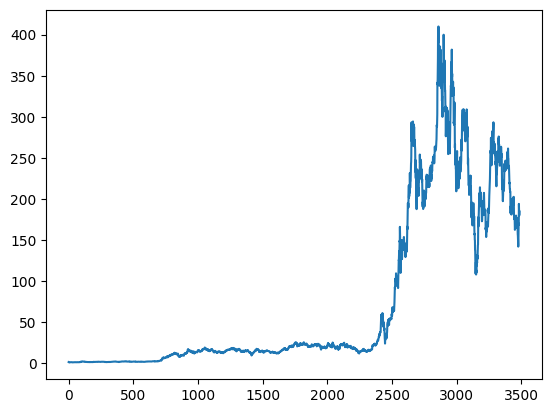

In [2]:
stock_data = yf.download('TSLA')
stock_data.head()


stock_selected_data = stock_data.reset_index()['Close']
plt.plot(stock_selected_data)


stock_selected_data=scaler.fit_transform(np.array(stock_selected_data).reshape(-1,1))


##splitting dataset into train and test split
training_size=int(len(stock_selected_data)*0.70)
test_size=len(stock_selected_data)-training_size
train_data,test_data=stock_selected_data[0:training_size,:],stock_selected_data[training_size:len(stock_selected_data),:1]

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

model = load_model('stock_ann_model.h5')

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(stock_selected_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(stock_selected_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(stock_selected_data)-1, :] = test_predict



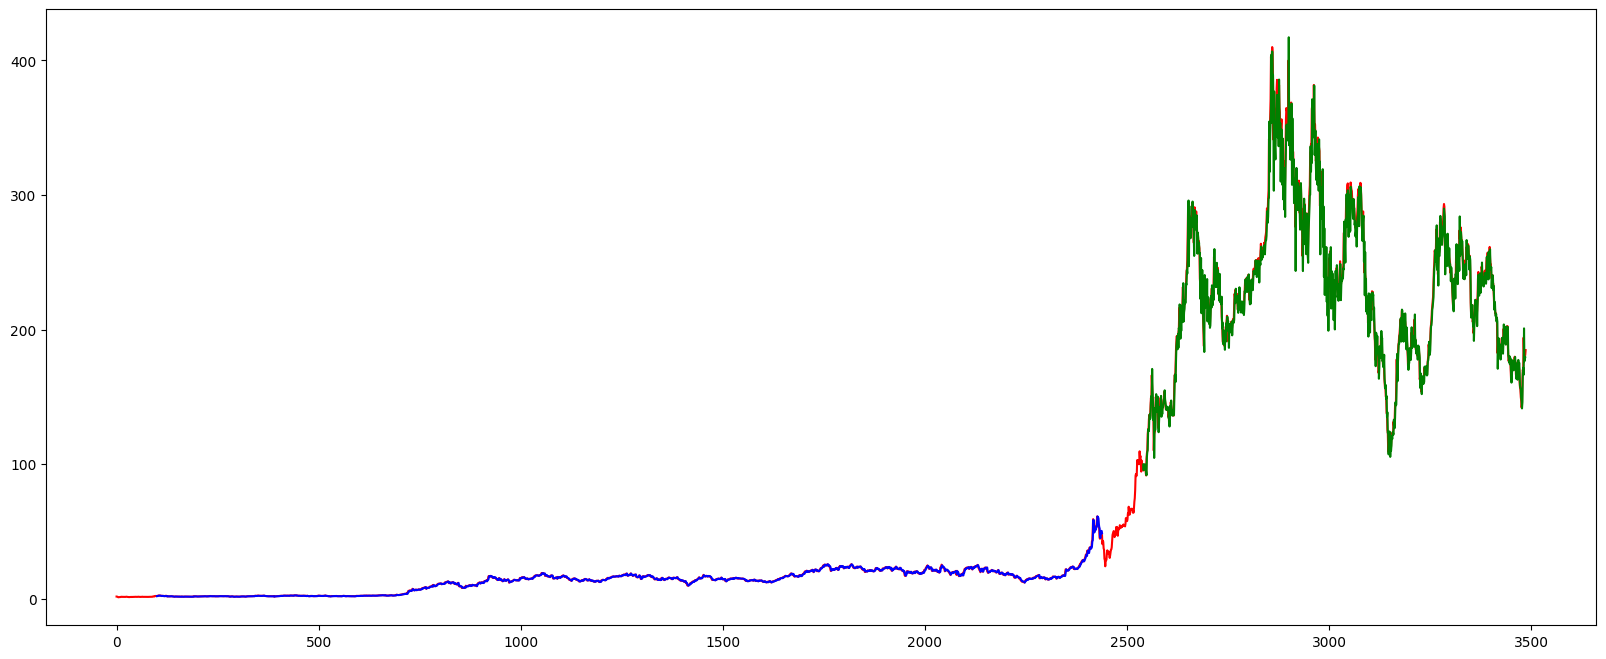

In [3]:
# plot baseline and predictions
plt.figure(figsize =(20, 8))
plt.plot(scaler.inverse_transform(stock_selected_data),'red')
plt.plot(trainPredictPlot,'blue')
plt.plot(testPredictPlot,'green')
plt.show()

In [11]:
# Initialize with the last 100 data points from test_data
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
n_days = 30  # Number of days to predict

for i in range(n_days):
    if len(temp_input) >= n_steps:
        # Prepare input for prediction
        x_input = np.array(temp_input[-n_steps:]).reshape((1, n_steps, 1))
        # Predict the next value
        yhat = model.predict(x_input, verbose=0)[0][0]
        # Append prediction to the output list
        lst_output.append(yhat)
        # Append prediction to temp_input to use for next prediction
        temp_input.append(yhat)
    else:
        # If we don't have enough data points, continue with the available data
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))
        yhat = model.predict(x_input, verbose=0)[0][0]
        lst_output.append(yhat)
        temp_input.append(yhat)

print(lst_output)


[0.4516485, 0.45108557, 0.44968882, 0.44814035, 0.44676363, 0.4456425, 0.4447206, 0.44389743, 0.4430865, 0.44223604, 0.44132742, 0.44036376, 0.43935806, 0.43832502, 0.4372765, 0.4362204, 0.43516165, 0.43410325, 0.43304753, 0.43199646, 0.43095222, 0.42991757, 0.42889467, 0.42788544, 0.42689192, 0.4259156, 0.42495772, 0.424019, 0.42310023, 0.42220193]


(30,)


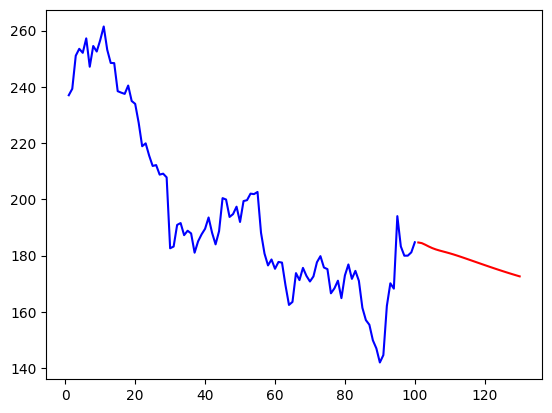

In [12]:
day_new=np.arange(1,101)
day_pred=np.arange(101,101+(n_days))

print(day_pred.shape)
scale_factor = 1/scaler.scale_

plt.plot(day_new,scaler.inverse_transform(stock_selected_data[len(stock_selected_data)-100:]),'blue') # len of stock_selected_data - 300 
plt.plot(day_pred,scale_factor*lst_output,'red')